<a href="https://colab.research.google.com/github/thomaschen01/NTCU-Machine-Learning/blob/main/ACS111106_ex1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

監督式學習:XGBoost

In [39]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from xgboost import XGBClassifier
import kagglehub
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/MyDrive/creditcard.csv"
data = pd.read_csv(path)
data['Class'] = data['Class'].astype(int)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE

In [41]:
RANDOM_SEED = 42
TEST_SIZE = 0.3

path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
data = pd.read_csv(f"{path}/creditcard.csv")

In [42]:
data['Class'] = data['Class'].astype(int)
data = data.drop(['Time'], axis=1)
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

fraud = data[data['Class'] == 1]
nonfraud = data[data['Class'] == 0]
print(f'Fraudulent:{len(fraud)}, non-fraudulent:{len(nonfraud)}')
print(f'the positive class (frauds) percentage: {len(fraud)}/{len(fraud) + len(nonfraud)} ({len(fraud)/(len(fraud) + len(nonfraud))*100:.3f}%)')

Fraudulent:492, non-fraudulent:284315
the positive class (frauds) percentage: 492/284807 (0.173%)


In [43]:
X = data.drop(columns=['Class']).to_numpy()
Y = data['Class'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=TEST_SIZE, random_state=RANDOM_SEED)

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [44]:
xgb_model = XGBClassifier(
    colsample_bytree=1.0,
    learning_rate=0.1,
    max_depth=6,
    n_estimators=200,
    subsample=0.8,
    scale_pos_weight=2.5,  # 強化處理類別不平衡
    eval_metric='logloss',
    tree_method='hist',
    random_state=RANDOM_SEED
)

In [45]:
xgb_model.fit(X_train_std, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [46]:
def evaluation(y_true, y_pred, model_name="Model"):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f'\n{model_name} Evaluation:')
    print('===' * 15)
    print('         Accuracy:', accuracy)
    print('  Precision Score:', precision)
    print('     Recall Score:', recall)
    print('         F1 Score:', f1)
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

y_prob = xgb_model.predict_proba(X_test_std)[:, 1]
threshold = 0.43
y_pred_custom = (y_prob > threshold).astype(int)

evaluation(y_test, y_pred_custom, model_name="XGBoost")


XGBoost Evaluation:
         Accuracy: 0.9996957035684608
  Precision Score: 0.9435483870967742
     Recall Score: 0.8602941176470589
         F1 Score: 0.9

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.94      0.86      0.90       136

    accuracy                           1.00     85443
   macro avg       0.97      0.93      0.95     85443
weighted avg       1.00      1.00      1.00     85443



非監督式學習:Kmeans

Fraudulent: 492, Non-Fraudulent: 284315
Fraud ratio: 0.173%
Optimal number of clusters (k): 2

ROC AUC Score: 0.7533


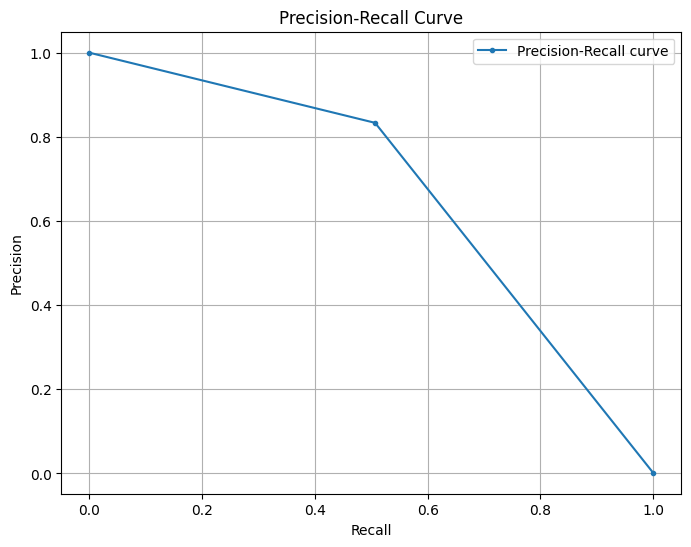

Best threshold by F1 score: 0.8333

Threshold = 0.833
Accuracy : 0.9989700736163291
Precision: 0.8333333333333334
Recall   : 0.5067567567567568
F1 Score : 0.6302521008403361

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.83      0.51      0.63       148

    accuracy                           1.00     85443
   macro avg       0.92      0.75      0.81     85443
weighted avg       1.00      1.00      1.00     85443



In [47]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import (
    classification_report, accuracy_score, precision_score, recall_score, f1_score,
    silhouette_score, roc_auc_score, precision_recall_curve
)
import matplotlib.pyplot as plt
import kagglehub

# === 基本設定 ===
RANDOM_SEED = 42
TEST_SIZE = 0.3
K_RANGE = range(2, 11)

def load_data():
    path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
    df = pd.read_csv(f"{path}/creditcard.csv")
    df['Class'] = df['Class'].astype(int)
    df.drop(columns=['Time'], inplace=True)
    df['Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))
    return df

def preprocess_data(df):
    X = df.drop(columns=['Class']).values
    y = df['Class'].values
    x_train, x_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_SEED
    )
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)
    return x_train, x_test, y_train, y_test

def sample_training_data(x_train, y_train, n_normal=5000, n_fraud=100):
    normal = x_train[y_train == 0][:n_normal]
    fraud = x_train[y_train == 1][:n_fraud]
    return np.vstack([normal, fraud])

def find_optimal_k(data, k_range):
    scores = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=500,
                        tol=1e-4, random_state=RANDOM_SEED, algorithm='elkan')
        kmeans.fit(data)
        score = silhouette_score(data, kmeans.labels_)
        scores.append(score)
    best_k = np.argmax(scores) + k_range.start
    return best_k, scores

def train_kmeans(data, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=20,
                    max_iter=700, tol=1e-4, random_state=RANDOM_SEED)
    kmeans.fit(data)
    return kmeans

def get_cluster_fraud_rates(y_true, cluster_labels, n_clusters):
    fraud_rates = np.zeros(n_clusters)
    for i in range(n_clusters):
        mask = (cluster_labels == i)
        if np.any(mask):
            fraud_rates[i] = np.mean(y_true[mask])
    return fraud_rates

def evaluate_threshold(y_true, scores, threshold):
    y_pred = (scores >= threshold).astype(int)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"\nThreshold = {threshold:.3f}")
    print(f"Accuracy : {accuracy:.16f}")
    print(f"Precision: {precision:.16f}")
    print(f"Recall   : {recall:.16f}")
    print(f"F1 Score : {f1:.16f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
data = load_data()
print(f"Fraudulent: {len(data[data['Class']==1])}, Non-Fraudulent: {len(data[data['Class']==0])}")
print(f"Fraud ratio: {data['Class'].mean()*100:.3f}%")

x_train, x_test, y_train, y_test = preprocess_data(data)
mix_x_train = sample_training_data(x_train, y_train, n_normal=5000, n_fraud=100)

optimal_k, silhouette_scores = find_optimal_k(mix_x_train, K_RANGE)
print(f"Optimal number of clusters (k): {optimal_k}")

kmeans = train_kmeans(mix_x_train, optimal_k)
test_cluster_labels = kmeans.predict(x_test)
# 計算每個群的詐欺比例（群內詐欺率）
cluster_fraud_rates = get_cluster_fraud_rates(y_test, test_cluster_labels, optimal_k)
# 取得每筆測試資料的異常分數(詐欺比例)
test_scores = cluster_fraud_rates[test_cluster_labels]
# 計算 ROC AUC
roc_auc = roc_auc_score(y_test, test_scores)
print(f"\nROC AUC Score: {roc_auc:.4f}")
# 畫 Precision-Recall 曲線
precision, recall, thresholds = precision_recall_curve(y_test, test_scores)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()
# 自動找出最佳閾值（F1 score 最大的點）
f1_scores = 2 * precision * recall / (precision + recall + 1e-8)
best_index = np.argmax(f1_scores)
best_threshold = thresholds[best_index] if best_index < len(thresholds) else 0.5
print(f"Best threshold by F1 score: {best_threshold:.4f}")
# 用最佳閾值評估模型
evaluate_threshold(y_test, test_scores, best_threshold)